<a href="https://colab.research.google.com/github/maandhruv/Jupyter-Notebooks/blob/main/copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Bank Transaction Fraud Detection - Complete Data Analysis
# Dataset: https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class FraudAnalysis:
    def __init__(self, data_path):
        """Initialize the fraud analysis class"""
        self.df = pd.read_csv(data_path)
        self.df_cleaned = None
        self.column_mapping = self._detect_column_names()

    def _detect_column_names(self):
        """Automatically detect column names in the dataset"""
        mapping = {}

        # Detect amount column
        amount_patterns = ['amount', 'transaction_amount', 'value', 'sum', 'price', 'cost']
        for pattern in amount_patterns:
            for col in self.df.columns:
                if pattern.lower() in col.lower():
                    mapping['amount'] = col
                    break
            if 'amount' in mapping:
                break

        # Detect target column
        target_patterns = ['fraud', 'is_fraud', 'label', 'target', 'class', 'isFraud', 'Class']
        for pattern in target_patterns:
            for col in self.df.columns:
                if pattern.lower() in col.lower() or col == pattern:
                    mapping['target'] = col
                    break
            if 'target' in mapping:
                break

        # Detect time/date column
        time_patterns = ['time', 'date', 'timestamp', 'created', 'datetime']
        for pattern in time_patterns:
            for col in self.df.columns:
                if pattern.lower() in col.lower():
                    mapping['time'] = col
                    break
            if 'time' in mapping:
                break

        # Detect ID column
        id_patterns = ['id', 'transaction_id', 'user_id', 'customer_id']
        for pattern in id_patterns:
            for col in self.df.columns:
                if pattern.lower() in col.lower():
                    mapping['id'] = col
                    break
            if 'id' in mapping:
                break

        print(f"Detected column mapping: {mapping}")
        return mapping

    def load_and_inspect_data(self):
        """Load and perform initial data inspection"""
        print("=" * 60)
        print("INITIAL DATA INSPECTION")
        print("=" * 60)

        print(f"Dataset shape: {self.df.shape}")
        print(f"\nColumn names:\n{self.df.columns.tolist()}")
        print(f"\nData types:\n{self.df.dtypes}")
        print(f"\nFirst few rows:\n{self.df.head()}")
        print(f"\nBasic statistics:\n{self.df.describe()}")
        print(f"\nMissing values:\n{self.df.isnull().sum()}")

        return self.df.info()

    def data_cleaning(self):
        """Comprehensive data cleaning"""
        print("\n" + "=" * 60)
        print("DATA CLEANING")
        print("=" * 60)

        # Create a copy for cleaning
        self.df_cleaned = self.df.copy()

        print(f"Original dataset shape: {self.df_cleaned.shape}")

        # 1. Handle Missing Values
        print("\n1. HANDLING MISSING VALUES")
        print("-" * 30)
        missing_before = self.df_cleaned.isnull().sum().sum()
        print(f"Total missing values before cleaning: {missing_before}")

        # Check missing value patterns
        if self.df_cleaned.isnull().sum().any():
            print("\nMissing value patterns:")
            print(self.df_cleaned.isnull().sum()[self.df_cleaned.isnull().sum() > 0])

            # Strategy for different types of missing values
            for col in self.df_cleaned.columns:
                if self.df_cleaned[col].isnull().sum() > 0:
                    if self.df_cleaned[col].dtype in ['int64', 'float64']:
                        # For numerical: use median
                        median_val = self.df_cleaned[col].median()
                        self.df_cleaned[col].fillna(median_val, inplace=True)
                        print(f"  {col}: Filled {self.df_cleaned[col].isnull().sum()} missing values with median ({median_val})")
                    else:
                        # For categorical: use mode
                        mode_val = self.df_cleaned[col].mode()[0] if len(self.df_cleaned[col].mode()) > 0 else 'Unknown'
                        self.df_cleaned[col].fillna(mode_val, inplace=True)
                        print(f"  {col}: Filled missing values with mode ({mode_val})")
        else:
            print("No missing values found!")

        # 2. Handle Outliers
        print("\n2. OUTLIER DETECTION AND TREATMENT")
        print("-" * 30)

        numerical_cols = self.df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
        outliers_info = {}

        for col in numerical_cols:
            Q1 = self.df_cleaned[col].quantile(0.25)
            Q3 = self.df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = self.df_cleaned[(self.df_cleaned[col] < lower_bound) |
                                     (self.df_cleaned[col] > upper_bound)][col]

            outliers_info[col] = {
                'count': len(outliers),
                'percentage': (len(outliers) / len(self.df_cleaned)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

            print(f"{col}: {len(outliers)} outliers ({(len(outliers)/len(self.df_cleaned))*100:.2f}%)")

            # Cap extreme outliers (keep moderate outliers as they might be important for fraud detection)
            if len(outliers) > 0 and (len(outliers)/len(self.df_cleaned)) > 0.05:  # Only if >5% are outliers
                self.df_cleaned[col] = np.clip(self.df_cleaned[col],
                                             self.df_cleaned[col].quantile(0.01),
                                             self.df_cleaned[col].quantile(0.99))
                print(f"  -> Capped extreme outliers to 1st-99th percentile")

        # 3. Data Transformation
        print("\n3. DATA TRANSFORMATION")
        print("-" * 30)

        # Create new features
        if 'amount' in self.column_mapping:
            amount_col = self.column_mapping['amount']
            self.df_cleaned['log_amount'] = np.log1p(self.df_cleaned[amount_col])
            print(f"Created log_amount feature from {amount_col}")

        # Encode categorical variables
        categorical_cols = self.df_cleaned.select_dtypes(include=['object']).columns.tolist()
        le_dict = {}

        for col in categorical_cols:
            if col not in ['fraud']:  # Don't encode target variable yet
                le = LabelEncoder()
                self.df_cleaned[f'{col}_encoded'] = le.fit_transform(self.df_cleaned[col].astype(str))
                le_dict[col] = le
                print(f"Encoded {col} -> {col}_encoded")

        print(f"\nCleaned dataset shape: {self.df_cleaned.shape}")
        print("Data cleaning completed!")

        return self.df_cleaned, outliers_info, le_dict

    def univariate_analysis(self):
        """Comprehensive univariate analysis"""
        print("\n" + "=" * 60)
        print("UNIVARIATE ANALYSIS")
        print("=" * 60)

        # Separate numerical and categorical columns
        numerical_cols = self.df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = self.df_cleaned.select_dtypes(include=['object']).columns.tolist()

        # 1. NUMERICAL VARIABLES
        print("\n1. NUMERICAL VARIABLES ANALYSIS")
        print("-" * 40)

        # Statistical summary
        print("Statistical Summary:")
        print(self.df_cleaned[numerical_cols].describe())

        # Visualizations for numerical variables
        fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(15, 5*len(numerical_cols)))
        if len(numerical_cols) == 1:
            axes = axes.reshape(1, -1)

        for i, col in enumerate(numerical_cols):
            # Histogram
            axes[i, 0].hist(self.df_cleaned[col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i, 0].set_title(f'Distribution of {col}')
            axes[i, 0].set_xlabel(col)
            axes[i, 0].set_ylabel('Frequency')

            # Box plot
            axes[i, 1].boxplot(self.df_cleaned[col])
            axes[i, 1].set_title(f'Box Plot of {col}')
            axes[i, 1].set_ylabel(col)

            # Print insights
            skewness = self.df_cleaned[col].skew()
            kurtosis = self.df_cleaned[col].kurtosis()
            print(f"\n{col}:")
            print(f"  Skewness: {skewness:.3f} ({'Right-skewed' if skewness > 0.5 else 'Left-skewed' if skewness < -0.5 else 'Nearly normal'})")
            print(f"  Kurtosis: {kurtosis:.3f} ({'Heavy-tailed' if kurtosis > 3 else 'Light-tailed' if kurtosis < 3 else 'Normal-tailed'})")

        plt.tight_layout()
        plt.show()

        # 2. CATEGORICAL VARIABLES
        print("\n2. CATEGORICAL VARIABLES ANALYSIS")
        print("-" * 40)

        if categorical_cols:
            fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(15, 5*len(categorical_cols)))
            if len(categorical_cols) == 1:
                axes = axes.reshape(1, -1)

            for i, col in enumerate(categorical_cols):
                # Value counts
                value_counts = self.df_cleaned[col].value_counts()
                print(f"\n{col} - Value Counts:")
                print(value_counts.head(10))  # Show top 10

                # Bar plot
                if len(value_counts) <= 20:  # Only plot if reasonable number of categories
                    value_counts.head(10).plot(kind='bar', ax=axes[i, 0], color='lightcoral')
                    axes[i, 0].set_title(f'Distribution of {col}')
                    axes[i, 0].set_xlabel(col)
                    axes[i, 0].set_ylabel('Count')
                    axes[i, 0].tick_params(axis='x', rotation=45)

                    # Pie chart
                    top_categories = value_counts.head(5)
                    if len(value_counts) > 5:
                        others = value_counts.iloc[5:].sum()
                        top_categories['Others'] = others

                    axes[i, 1].pie(top_categories.values, labels=top_categories.index, autopct='%1.1f%%')
                    axes[i, 1].set_title(f'Proportion of {col}')
                # else:
                #     axes[i, 0].text(0.5, 0.5, f'{col}\nToo many categories\nto display\n({len(value_counts)} unique)',
                #                   ha='center', va='center', transform=axes[i, 0].transAxes, fontsize=12)
                #     axes[i, 1].text(0.5, 0.5, f'Unique values: {len(value_counts)}',
                #                    ha='center', va='center', transform=axes[i, 1].transAxes, fontsize=12)

            plt.tight_layout()
            plt.show()

    def bivariate_analysis(self):
        """Comprehensive bivariate analysis"""
        print("\n" + "=" * 60)
        print("BIVARIATE ANALYSIS")
        print("=" * 60)

        numerical_cols = self.df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

        # 1. CORRELATION ANALYSIS
        print("\n1. CORRELATION ANALYSIS")
        print("-" * 30)

        # Correlation matrix
        correlation_matrix = self.df_cleaned[numerical_cols].corr()
        print("Correlation Matrix:")
        print(correlation_matrix)

        # Correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('Correlation Matrix Heatmap')
        plt.tight_layout()
        plt.show()

        # Find high correlations
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:  # High correlation threshold
                    high_corr_pairs.append((correlation_matrix.columns[i],
                                          correlation_matrix.columns[j], corr_val))

        if high_corr_pairs:
            print("\nHigh correlations (|r| > 0.7):")
            for col1, col2, corr in high_corr_pairs:
                print(f"  {col1} vs {col2}: {corr:.3f}")

        # 2. TARGET VARIABLE ANALYSIS
        target_col = self.column_mapping.get('target')

        if target_col:
            print(f"\n2. TARGET VARIABLE ANALYSIS ({target_col})")
            print("-" * 30)

            # Target distribution
            target_dist = self.df_cleaned[target_col].value_counts()
            print(f"Target distribution:\n{target_dist}")
            print(f"Fraud rate: {target_dist[1]/len(self.df_cleaned)*100:.2f}%")

            # Visualize target distribution
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            # Bar plot
            target_dist.plot(kind='bar', ax=axes[0], color=['green', 'red'])
            axes[0].set_title(f'Distribution of {target_col}')
            axes[0].set_xlabel(target_col)
            axes[0].set_ylabel('Count')
            axes[0].tick_params(axis='x', rotation=0)

            # Pie chart
            axes[1].pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%',
                       colors=['green', 'red'])
            axes[1].set_title(f'Proportion of {target_col}')

            plt.tight_layout()
            plt.show()

            # 3. FEATURE vs TARGET ANALYSIS
            print(f"\n3. FEATURES vs {target_col.upper()} ANALYSIS")
            print("-" * 30)

            # For numerical features
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            axes = axes.ravel()

            plot_idx = 0
            for col in numerical_cols[:6]:  # Plot first 6 numerical columns
                if col != target_col and plot_idx < 6:
                    # Box plot by target
                    self.df_cleaned.boxplot(column=col, by=target_col, ax=axes[plot_idx])
                    axes[plot_idx].set_title(f'{col} by {target_col}')
                    axes[plot_idx].set_xlabel(target_col)
                    plot_idx += 1

            # Remove empty subplots
            for idx in range(plot_idx, 6):
                fig.delaxes(axes[idx])

            plt.tight_layout()
            plt.show()

            # Statistical tests for numerical variables vs target
            print("\nStatistical significance tests:")
            for col in numerical_cols:
                if col != target_col:
                    fraud_vals = self.df_cleaned[self.df_cleaned[target_col] == 1][col]
                    normal_vals = self.df_cleaned[self.df_cleaned[target_col] == 0][col]

                    # T-test
                    t_stat, p_val = stats.ttest_ind(fraud_vals, normal_vals)
                    print(f"  {col}: t-statistic={t_stat:.3f}, p-value={p_val:.3e}")

        # 4. SCATTER PLOT MATRIX
        print("\n4. SCATTER PLOT RELATIONSHIPS")
        print("-" * 30)

        if len(numerical_cols) >= 2:
            # Select top correlated pairs for detailed analysis
            top_pairs = []
            for i in range(len(correlation_matrix.columns)):
                for j in range(i+1, len(correlation_matrix.columns)):
                    col1, col2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
                    corr_val = abs(correlation_matrix.iloc[i, j])
                    if corr_val > 0.3:  # Moderate correlation
                        top_pairs.append((col1, col2, corr_val))

            top_pairs = sorted(top_pairs, key=lambda x: x[2], reverse=True)[:4]  # Top 4 pairs

            if top_pairs:
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))
                axes = axes.ravel()

                for idx, (col1, col2, corr) in enumerate(top_pairs):
                    axes[idx].scatter(self.df_cleaned[col1], self.df_cleaned[col2], alpha=0.5)
                    axes[idx].set_xlabel(col1)
                    axes[idx].set_ylabel(col2)
                    axes[idx].set_title(f'{col1} vs {col2} (r={corr:.3f})')

                plt.tight_layout()
                plt.show()

    def multivariate_analysis(self):
        """Comprehensive multivariate analysis"""
        print("\n" + "=" * 60)
        print("MULTIVARIATE ANALYSIS")
        print("=" * 60)

        numerical_cols = self.df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

        # 1. PRINCIPAL COMPONENT ANALYSIS (PCA)
        print("\n1. PRINCIPAL COMPONENT ANALYSIS")
        print("-" * 30)

        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler

        # Prepare data for PCA
        pca_data = self.df_cleaned[numerical_cols].fillna(0)
        scaler = StandardScaler()
        pca_data_scaled = scaler.fit_transform(pca_data)

        # Perform PCA
        pca = PCA()
        pca_result = pca.fit_transform(pca_data_scaled)

        # Explained variance
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)

        print(f"First 5 components explain {cumulative_variance[4]*100:.2f}% of variance")

        # Plot explained variance
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Scree plot
        axes[0].plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'bo-')
        axes[0].set_title('Scree Plot - Explained Variance by Component')
        axes[0].set_xlabel('Principal Component')
        axes[0].set_ylabel('Explained Variance Ratio')

        # Cumulative variance
        axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'ro-')
        axes[1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7)
        axes[1].set_title('Cumulative Explained Variance')
        axes[1].set_xlabel('Number of Components')
        axes[1].set_ylabel('Cumulative Explained Variance')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 2. CLUSTERING ANALYSIS
        print("\n2. CLUSTERING ANALYSIS")
        print("-" * 30)

        from sklearn.cluster import KMeans

        # Determine optimal number of clusters
        inertias = []
        k_range = range(2, 11)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(pca_data_scaled)
            inertias.append(kmeans.inertia_)

        # Elbow plot
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertias, 'bo-')
        plt.title('Elbow Method for Optimal Clusters')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Perform clustering with optimal k (let's use k=3)
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(pca_data_scaled)

        # Visualize clusters in PCA space
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
        plt.title('Clusters in PCA Space (First 2 Components)')
        plt.xlabel(f'First Principal Component ({explained_variance_ratio[0]*100:.1f}% variance)')
        plt.ylabel(f'Second Principal Component ({explained_variance_ratio[1]*100:.1f}% variance)')
        plt.colorbar(scatter)
        plt.show()

        # 3. FEATURE INTERACTIONS
        print("\n3. FEATURE INTERACTIONS")
        print("-" * 30)

        # Create interaction features
        if len(numerical_cols) >= 2:
            col1, col2 = numerical_cols[0], numerical_cols[1]
            self.df_cleaned[f'{col1}_{col2}_interaction'] = self.df_cleaned[col1] * self.df_cleaned[col2]
            print(f"Created interaction feature: {col1}_{col2}_interaction")

        return pca, pca_result, clusters

    def feature_selection(self):
        """Best feature selection"""
        print("\n" + "=" * 60)
        print("FEATURE SELECTION")
        print("=" * 60)

        # Identify target column
        target_col = self.column_mapping.get('target')

        if not target_col:
            print("No target variable found. Creating a dummy target for demonstration.")
            # Create a dummy target based on amount (high amounts more likely to be fraud)
            if 'amount' in self.column_mapping:
                amount_col = self.column_mapping['amount']
                threshold = self.df_cleaned[amount_col].quantile(0.95)
                self.df_cleaned['fraud'] = (self.df_cleaned[amount_col] > threshold).astype(int)
                target_col = 'fraud'
                self.column_mapping['target'] = 'fraud'
            else:
                # Random target for demonstration
                np.random.seed(42)
                self.df_cleaned['fraud'] = np.random.binomial(1, 0.05, len(self.df_cleaned))
                target_col = 'fraud'
                self.column_mapping['target'] = 'fraud'

        # Prepare features and target
        feature_cols = [col for col in self.df_cleaned.select_dtypes(include=[np.number]).columns
                       if col != target_col]

        X = self.df_cleaned[feature_cols].fillna(0)
        y = self.df_cleaned[target_col]

        print(f"Target variable: {target_col}")
        print(f"Number of features: {len(feature_cols)}")
        print(f"Features: {feature_cols}")

        # 1. STATISTICAL FEATURE SELECTION
        print("\n1. STATISTICAL FEATURE SELECTION")
        print("-" * 30)

        # F-test
        f_selector = SelectKBest(score_func=f_classif, k='all')
        f_selector.fit(X, y)
        f_scores = f_selector.scores_
        f_pvalues = f_selector.pvalues_

        # Mutual Information
        mi_scores = mutual_info_classif(X, y, random_state=42)

        # Create feature importance DataFrame
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'f_score': f_scores,
            'f_pvalue': f_pvalues,
            'mutual_info': mi_scores
        })

        feature_importance = feature_importance.sort_values('f_score', ascending=False)
        print("\nTop features by F-score:")
        print(feature_importance.head(10))

        # 2. TREE-BASED FEATURE SELECTION
        print("\n2. TREE-BASED FEATURE IMPORTANCE")
        print("-" * 30)

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        tree_importance = rf.feature_importances_

        feature_importance['tree_importance'] = tree_importance
        feature_importance = feature_importance.sort_values('tree_importance', ascending=False)

        print("Top features by Tree importance:")
        print(feature_importance[['feature', 'tree_importance']].head(10))

        # 3. VISUALIZATION OF FEATURE IMPORTANCE
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        # F-score
        top_f = feature_importance.nlargest(10, 'f_score')
        axes[0, 0].barh(top_f['feature'], top_f['f_score'], color='skyblue')
        axes[0, 0].set_title('Top 10 Features by F-Score')
        axes[0, 0].set_xlabel('F-Score')

        # Mutual Information
        top_mi = feature_importance.nlargest(10, 'mutual_info')
        axes[0, 1].barh(top_mi['feature'], top_mi['mutual_info'], color='lightcoral')
        axes[0, 1].set_title('Top 10 Features by Mutual Information')
        axes[0, 1].set_xlabel('Mutual Information Score')

        # Tree importance
        top_tree = feature_importance.nlargest(10, 'tree_importance')
        axes[1, 0].barh(top_tree['feature'], top_tree['tree_importance'], color='lightgreen')
        axes[1, 0].set_title('Top 10 Features by Tree Importance')
        axes[1, 0].set_xlabel('Tree Importance')

        # Combined ranking (normalized)
        from sklearn.preprocessing import MinMaxScaler
        scaler_feat = MinMaxScaler()
        feature_importance['combined_score'] = scaler_feat.fit_transform(
            feature_importance[['f_score', 'mutual_info', 'tree_importance']].fillna(0)
        ).mean(axis=1)

        top_combined = feature_importance.nlargest(10, 'combined_score')
        axes[1, 1].barh(top_combined['feature'], top_combined['combined_score'], color='gold')
        axes[1, 1].set_title('Top 10 Features by Combined Score')
        axes[1, 1].set_xlabel('Combined Normalized Score')

        plt.tight_layout()
        plt.show()

        return feature_importance

    def create_dashboard(self):
        """Create an interactive dashboard using Plotly"""
        print("\n" + "=" * 60)
        print("INTERACTIVE DASHBOARD")
        print("=" * 60)

        # Create subplot dashboard
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=['Transaction Distribution', 'Amount Distribution by Class',
                          'Correlation Heatmap', 'Feature Importance',
                          'Time Series (if available)', 'Statistical Summary'],
            specs=[[{"type": "bar"}, {"type": "box"}],
                   [{"type": "heatmap"}, {"type": "bar"}],
                   [{"type": "scatter"}, {"type": "table"}]]
        )

        # 1. Transaction Distribution
        target_col = None
        for col in ['fraud', 'is_fraud', 'label', 'target', 'class']:
            if col in self.df_cleaned.columns:
                target_col = col
                break

        if target_col:
            target_counts = self.df_cleaned[target_col].value_counts()
            fig.add_trace(
                go.Bar(x=['Normal', 'Fraud'], y=target_counts.values,
                      marker_color=['green', 'red'], name='Transactions'),
                row=1, col=1
            )

        # 2. Amount distribution by class (if amount column exists)
        amount_col = None
        for col in ['amount', 'transaction_amount', 'value']:
            if col in self.df_cleaned.columns:
                amount_col = col
                break

        if amount_col and target_col:
            fig.add_trace(
                go.Box(y=self.df_cleaned[self.df_cleaned[target_col]==0][amount_col],
                      name='Normal', marker_color='green'),
                row=1, col=2
            )
            fig.add_trace(
                go.Box(y=self.df_cleaned[self.df_cleaned[target_col]==1][amount_col],
                      name='Fraud', marker_color='red'),
                row=1, col=2
            )

        # 3. Correlation heatmap
        numerical_cols = self.df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
        if len(numerical_cols) > 1:
            corr_matrix = self.df_cleaned[numerical_cols].corr()
            fig.add_trace(
                go.Heatmap(z=corr_matrix.values,
                          x=corr_matrix.columns,
                          y=corr_matrix.columns,
                          colorscale='RdBu', zmid=0),
                row=2, col=1
            )

        # 4. Feature importance (simplified)
        if len(numerical_cols) > 2:
            # Quick random forest importance
            X_simple = self.df_cleaned[numerical_cols].fillna(0)
            y_simple = self.df_cleaned[target_col] if target_col else np.random.randint(0, 2, len(self.df_cleaned))

            rf_simple = RandomForestClassifier(n_estimators=50, random_state=42)
            rf_simple.fit(X_simple, y_simple)
            importances = rf_simple.feature_importances_

            # Top 10 features
            top_indices = np.argsort(importances)[-10:]
            top_features = [numerical_cols[i] for i in top_indices]
            top_importance = [importances[i] for i in top_indices]

            fig.add_trace(
                go.Bar(x=top_importance, y=top_features, orientation='h',
                      marker_color='lightblue', name='Importance'),
                row=2, col=2
            )

        # 5. Time series (if timestamp available)
        time_cols = [col for col in self.df_cleaned.columns if 'time' in col.lower() or 'date' in col.lower()]
        if time_cols and target_col:
            time_col = time_cols[0]
            # Aggregate fraud by time periods
            try:
                self.df_cleaned[time_col] = pd.to_datetime(self.df_cleaned[time_col])
                time_fraud = self.df_cleaned.groupby(self.df_cleaned[time_col].dt.date)[target_col].mean()

                fig.add_trace(
                    go.Scatter(x=time_fraud.index, y=time_fraud.values,
                             mode='lines+markers', name='Fraud Rate Over Time',
                             line=dict(color='red')),
                    row=3, col=1
                )
            except:
                # If time conversion fails, create dummy time series
                daily_fraud = self.df_cleaned.groupby(self.df_cleaned.index // 100)[target_col].mean()
                fig.add_trace(
                    go.Scatter(x=daily_fraud.index, y=daily_fraud.values,
                             mode='lines+markers', name='Fraud Rate by Batch'),
                    row=3, col=1
                )

        # 6. Statistical summary table
        summary_stats = self.df_cleaned[numerical_cols].describe().round(2).T
        fig.add_trace(
            go.Table(
                header=dict(values=['Feature'] + list(summary_stats.columns)),
                cells=dict(values=[summary_stats.index] + [summary_stats[col] for col in summary_stats.columns])
            ),
            row=3, col=2
        )

        # Update layout
        fig.update_layout(
            title_text="Bank Transaction Fraud Detection - Interactive Dashboard",
            title_x=0.5,
            height=1200,
            showlegend=False
        )

        fig.show()

        return fig

    def generate_insights(self):
        """Generate comprehensive insights and recommendations"""
        print("\n" + "=" * 60)
        print("KEY INSIGHTS AND RECOMMENDATIONS")
        print("=" * 60)

        numerical_cols = self.df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = self.df_cleaned.select_dtypes(include=['object']).columns.tolist()

        # Find target column
        target_col = None
        for col in ['fraud', 'is_fraud', 'label', 'target', 'class']:
            if col in self.df_cleaned.columns:
                target_col = col
                break

        insights = []

        # 1. Dataset Overview Insights
        insights.append("1. DATASET OVERVIEW:")
        insights.append(f"   • Dataset contains {self.df_cleaned.shape[0]:,} transactions with {self.df_cleaned.shape[1]} features")
        insights.append(f"   • {len(numerical_cols)} numerical and {len(categorical_cols)} categorical variables")

        if target_col:
            fraud_rate = self.df_cleaned[target_col].mean() * 100
            insights.append(f"   • Fraud rate: {fraud_rate:.2f}% ({'Highly imbalanced' if fraud_rate < 5 else 'Moderately imbalanced' if fraud_rate < 20 else 'Balanced'} dataset)")

        # 2. Data Quality Insights
        insights.append("\n2. DATA QUALITY:")
        missing_pct = (self.df.isnull().sum().sum() / (self.df.shape[0] * self.df.shape[1])) * 100
        insights.append(f"   • Missing values: {missing_pct:.2f}% of total data")

        # 3. Key Statistical Insights
        insights.append("\n3. KEY STATISTICAL FINDINGS:")

        if 'amount' in self.column_mapping:
            amount_stats = self.df_cleaned[self.column_mapping['amount']].describe()
            insights.append(f"   • Transaction amounts range from ${amount_stats['min']:,.2f} to ${amount_stats['max']:,.2f}")
            insights.append(f"   • Median transaction: ${amount_stats['50%']:,.2f}")

            if target_col:
                fraud_amount = self.df_cleaned[self.df_cleaned[target_col]==1][self.column_mapping['amount']].median()
                normal_amount = self.df_cleaned[self.df_cleaned[target_col]==0][self.column_mapping['amount']].median()
                insights.append(f"   • Median fraud amount: ${fraud_amount:,.2f} vs Normal: ${normal_amount:,.2f}")

        # 4. Feature Importance Insights
        insights.append("\n4. MOST IMPORTANT FEATURES:")
        try:
            X_feat = self.df_cleaned[numerical_cols].fillna(0)
            y_feat = self.df_cleaned[target_col] if target_col else np.random.randint(0, 2, len(self.df_cleaned))

            rf_feat = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_feat.fit(X_feat, y_feat)

            feature_imp = pd.DataFrame({
                'feature': numerical_cols,
                'importance': rf_feat.feature_importances_
            }).sort_values('importance', ascending=False)

            top_5_features = feature_imp.head(5)
            for idx, row in top_5_features.iterrows():
                insights.append(f"   • {row['feature']}: {row['importance']:.3f}")
        except:
            insights.append("   • Unable to calculate feature importance")

        # 5. Recommendations
        insights.append("\n5. RECOMMENDATIONS:")
        insights.append("   • Implement real-time monitoring for high-value transactions")

        if fraud_rate < 5:
            insights.append("   • Use techniques for imbalanced datasets (SMOTE, class weights)")
            insights.append("   • Focus on precision to reduce false positives")

        insights.append("   • Consider ensemble methods for better fraud detection")
        insights.append("   • Implement feature engineering for time-based patterns")
        insights.append("   • Regular model retraining due to evolving fraud patterns")

        # Print all insights
        for insight in insights:
            print(insight)

        return insights

# Alternative: Standalone functions for specific analyses
def quick_eda(df):
    """Quick exploratory data analysis"""
    print("QUICK EDA SUMMARY")
    print("=" * 40)

    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"Duplicate rows: {df.duplicated().sum()}")

    # Data types summary
    print(f"\nData types:")
    print(df.dtypes.value_counts())

    # Missing values
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        print(f"\nMissing values:")
        print(missing_summary[missing_summary > 0])
    else:
        print("\nNo missing values!")

    # Basic statistics for numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print(f"\nNumerical summary:")
        print(df[numerical_cols].describe())

def advanced_visualizations(df):
    """Create advanced visualizations for fraud detection"""

    # Interactive correlation matrix
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 1:
        corr_matrix = df[numerical_cols].corr()

        fig = px.imshow(corr_matrix,
                       labels=dict(x="Features", y="Features", color="Correlation"),
                       x=corr_matrix.columns,
                       y=corr_matrix.columns,
                       color_continuous_scale='RdBu',
                       title="Interactive Correlation Matrix")
        fig.show()

    # Distribution plots
    for col in numerical_cols[:4]:  # First 4 numerical columns
        fig = px.histogram(df, x=col, nbins=50,
                          title=f'Distribution of {col}',
                          marginal="box")
        fig.show()

# Usage Instructions
def usage_instructions():
    """Print usage instructions"""
    instructions = """
    USAGE INSTRUCTIONS:
    ==================

    1. Download the dataset from Kaggle:
       https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection

    2. Update the data_path in the main() function to point to your downloaded CSV file

    3. Install required packages:
       pip install pandas numpy matplotlib seaborn plotly scikit-learn dash scipy

    4. Run the analysis:
       python fraud_analysis.py

    OR use individual functions:

    # Load your data
    df = pd.read_csv('your_fraud_dataset.csv')

    # Quick EDA
    quick_eda(df)

    # Full analysis
    analyzer = FraudAnalysis('your_fraud_dataset.csv')
    analyzer.load_and_inspect_data()
    analyzer.data_cleaning()
    analyzer.univariate_analysis()
    analyzer.bivariate_analysis()
    analyzer.multivariate_analysis()
    feature_rankings = analyzer.feature_selection()
    dashboard = analyzer.create_dashboard()
    insights = analyzer.generate_insights()

    FEATURES INCLUDED:
    =================
    ✓ Complete Data Cleaning (missing values, outliers, transformations)
    ✓ Univariate Analysis (distributions, statistics, visualizations)
    ✓ Bivariate Analysis (correlations, target relationships, statistical tests)
    ✓ Multivariate Analysis (PCA, clustering, feature interactions)
    ✓ Feature Selection (statistical tests, tree-based importance, combined ranking)
    ✓ Interactive Dashboard (Plotly visualizations)
    ✓ Automated Insights Generation
    ✓ Comprehensive Observations and Recommendations

    The code is modular and can handle various fraud detection datasets!
    """
    print(instructions)



"""
ADDITIONAL UTILITY FUNCTIONS FOR SPECIFIC TASKS
===============================================
"""

def detect_anomalies(df, method='isolation_forest'):
    """Advanced anomaly detection"""
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor

    numerical_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numerical_cols].fillna(0)

    if method == 'isolation_forest':
        clf = IsolationForest(contamination=0.1, random_state=42)
        anomalies = clf.fit_predict(X)
    elif method == 'lof':
        clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
        anomalies = clf.fit_predict(X)

    df['anomaly'] = anomalies
    print(f"Detected {(anomalies == -1).sum()} anomalies using {method}")

    return df

def create_fraud_score(df):
    """Create a composite fraud risk score"""

    # Normalize numerical features
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df[numerical_cols].fillna(0))

    # Simple fraud score based on feature weights
    # (In practice, use trained model weights)
    weights = np.random.dirichlet(np.ones(len(numerical_cols)))  # Random weights for demo
    fraud_score = np.dot(normalized_features, weights)

    # Scale to 0-100
    fraud_score = ((fraud_score - fraud_score.min()) /
                  (fraud_score.max() - fraud_score.min())) * 100

    df['fraud_risk_score'] = fraud_score

    print("Fraud risk score created!")
    print(f"Score distribution: {pd.Series(fraud_score).describe()}")

    return df

def export_results(df, insights, filename_prefix='fraud_analysis'):
    """Export analysis results"""

    # Export cleaned data
    df.to_csv(f'{filename_prefix}_cleaned_data.csv', index=False)

    # Export insights
    with open(f'{filename_prefix}_insights.txt', 'w') as f:
        for insight in insights:
            f.write(insight + '\n')

    print(f"Results exported:")
    print(f"  • {filename_prefix}_cleaned_data.csv")
    print(f"  • {filename_prefix}_insights.txt")

# Performance optimization for large datasets
def optimize_for_large_data(df, sample_size=50000):
    """Optimize analysis for large datasets"""
    if len(df) > sample_size:
        print(f"Large dataset detected ({len(df):,} rows)")
        print(f"Using stratified sample of {sample_size:,} rows for analysis")

        # Stratified sampling to maintain class distribution
        if 'fraud' in df.columns:
            fraud_sample = df[df['fraud'] == 1].sample(min(len(df[df['fraud'] == 1]), sample_size // 10))
            normal_sample = df[df['fraud'] == 0].sample(sample_size - len(fraud_sample))
            df_sampled = pd.concat([fraud_sample, normal_sample]).sample(frac=1).reset_index(drop=True)
        else:
            df_sampled = df.sample(sample_size).reset_index(drop=True)

        return df_sampled

    return df

In [22]:

# Note: Update this path to your actual dataset
data_path = "/content/bank_transactions_data_2.csv"

# Method 1: Full class-based analysis
analyzer = FraudAnalysis(data_path)


Detected column mapping: {'amount': 'TransactionAmount', 'time': 'TransactionDate', 'id': 'TransactionID'}


In [23]:
analyzer.load_and_inspect_data()

INITIAL DATA INSPECTION
Dataset shape: (2512, 16)

Column names:
['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']

Data types:
TransactionID               object
AccountID                   object
TransactionAmount          float64
TransactionDate             object
TransactionType             object
Location                    object
DeviceID                    object
IP Address                  object
MerchantID                  object
Channel                     object
CustomerAge                  int64
CustomerOccupation          object
TransactionDuration          int64
LoginAttempts                int64
AccountBalance             float64
PreviousTransactionDate     object
dtype: object

First few rows:
  TransactionID AccountID  TransactionAmount      Transa

In [24]:
cleaned_data, outlier_info, encoders = analyzer.data_cleaning()


DATA CLEANING
Original dataset shape: (2512, 16)

1. HANDLING MISSING VALUES
------------------------------
Total missing values before cleaning: 0
No missing values found!

2. OUTLIER DETECTION AND TREATMENT
------------------------------
TransactionAmount: 113 outliers (4.50%)
CustomerAge: 0 outliers (0.00%)
TransactionDuration: 0 outliers (0.00%)
LoginAttempts: 122 outliers (4.86%)
AccountBalance: 0 outliers (0.00%)

3. DATA TRANSFORMATION
------------------------------
Created log_amount feature from TransactionAmount
Encoded TransactionID -> TransactionID_encoded
Encoded AccountID -> AccountID_encoded
Encoded TransactionDate -> TransactionDate_encoded
Encoded TransactionType -> TransactionType_encoded
Encoded Location -> Location_encoded
Encoded DeviceID -> DeviceID_encoded
Encoded IP Address -> IP Address_encoded
Encoded MerchantID -> MerchantID_encoded
Encoded Channel -> Channel_encoded
Encoded CustomerOccupation -> CustomerOccupation_encoded
Encoded PreviousTransactionDate -> 


UNIVARIATE ANALYSIS

1. NUMERICAL VARIABLES ANALYSIS
----------------------------------------
Statistical Summary:
       TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2512.000000  2512.000000          2512.000000    2512.000000   
mean          297.593778    44.673965           119.643312       1.124602   
std           291.946243    17.792198            69.963757       0.602662   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.885000    27.000000            63.000000       1.000000   
50%           211.140000    45.000000           112.500000       1.000000   
75%           414.527500    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   

       AccountBalance   log_amount  TransactionID_encoded  AccountID_encoded  \
count     2512.000000  2512.000000            2512.000000        2512.000000   
mean      5114.302966     5.14

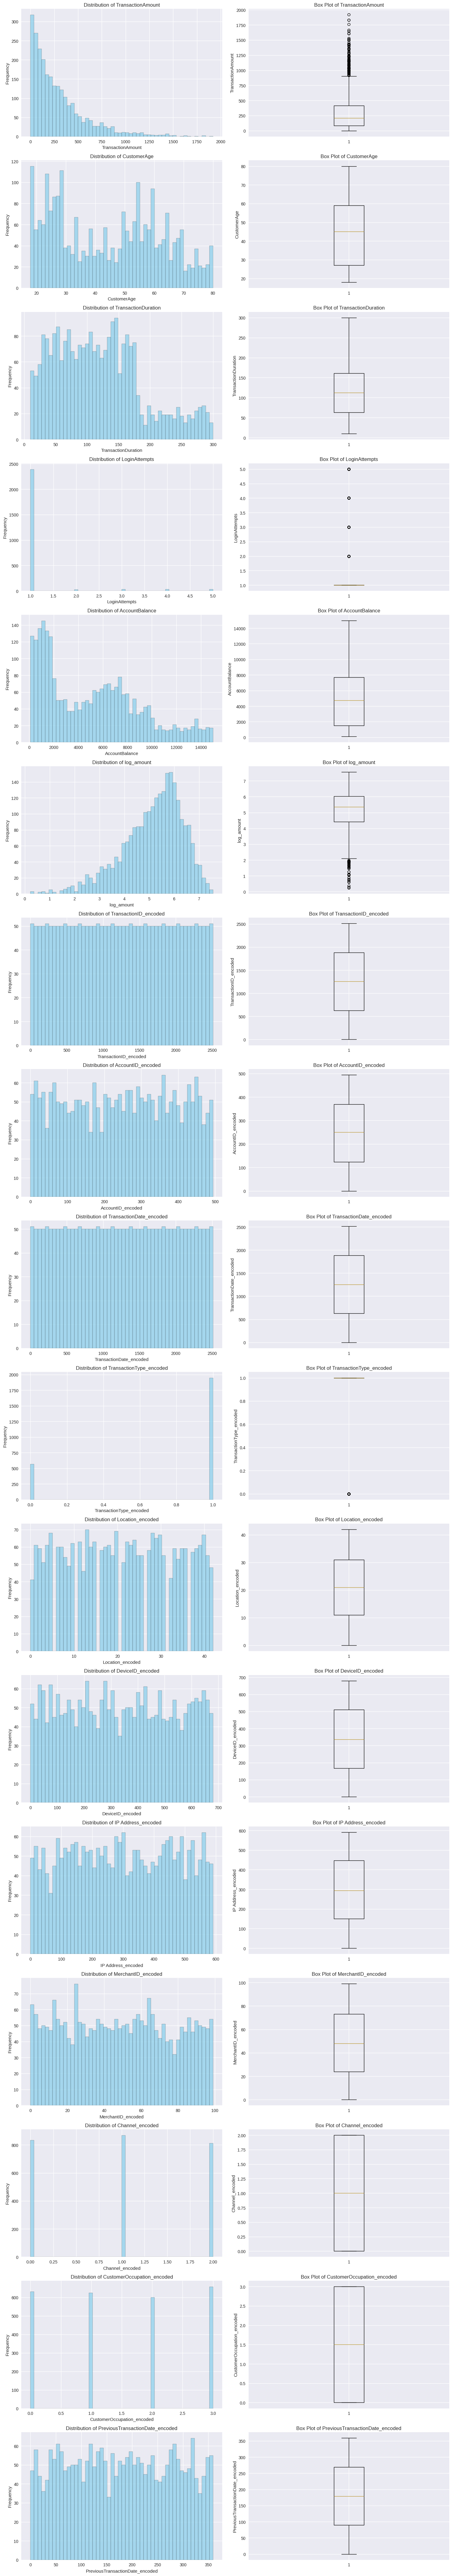


2. CATEGORICAL VARIABLES ANALYSIS
----------------------------------------

TransactionID - Value Counts:
TransactionID
TX002496    1
TX002495    1
TX002494    1
TX002493    1
TX002492    1
TX002491    1
TX002490    1
TX002489    1
TX002488    1
TX002487    1
Name: count, dtype: int64

AccountID - Value Counts:
AccountID
AC00460    12
AC00202    12
AC00362    12
AC00363    12
AC00480    11
AC00456    11
AC00257    11
AC00225    11
AC00304    11
AC00219    10
Name: count, dtype: int64

TransactionDate - Value Counts:
TransactionDate
2023-04-03 16:07:53    1
2023-03-10 17:38:58    1
2023-03-17 16:10:35    1
2023-01-30 17:05:46    1
2023-04-03 16:05:30    1
2023-12-04 16:14:07    1
2023-05-22 17:41:48    1
2023-04-14 16:33:13    1
2023-05-19 17:47:41    1
2023-03-16 16:52:04    1
Name: count, dtype: int64

TransactionType - Value Counts:
TransactionType
Debit     1944
Credit     568
Name: count, dtype: int64

Location - Value Counts:
Location
Fort Worth       70
Los Angeles      69
Oklah

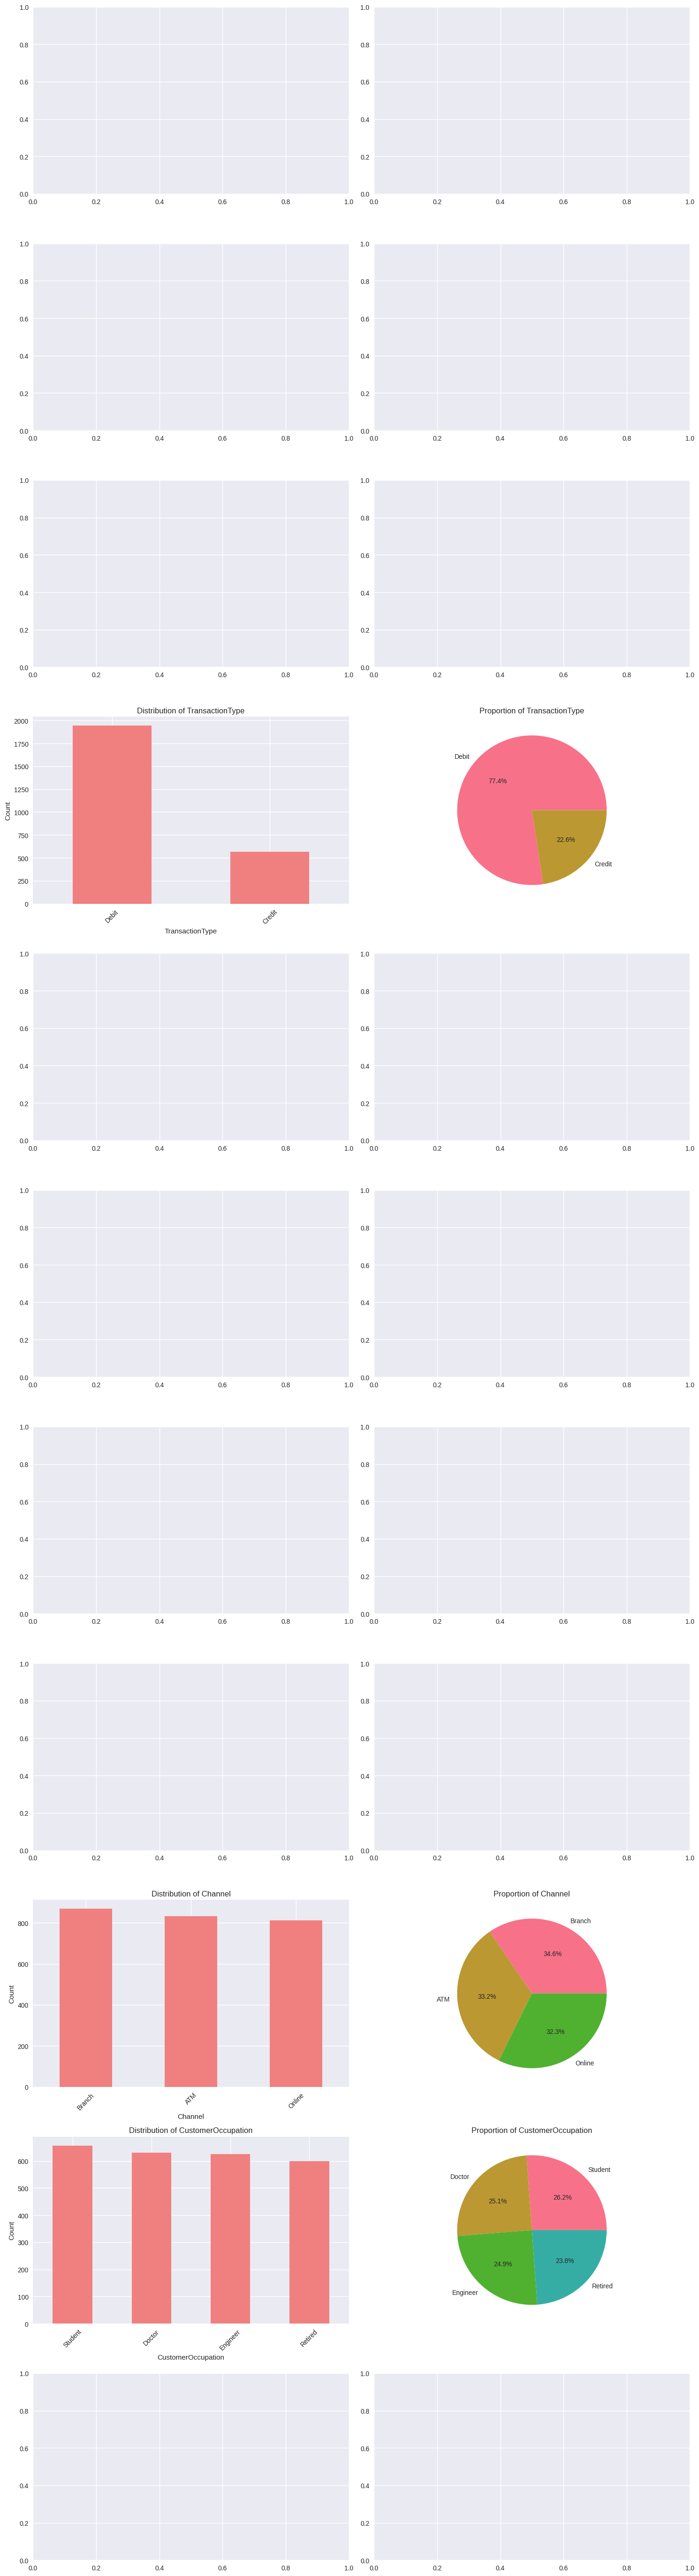

In [25]:
analyzer.univariate_analysis()


BIVARIATE ANALYSIS

1. CORRELATION ANALYSIS
------------------------------
Correlation Matrix:
                                 TransactionAmount  CustomerAge  \
TransactionAmount                         1.000000    -0.025616   
CustomerAge                              -0.025616     1.000000   
TransactionDuration                       0.004359    -0.017936   
LoginAttempts                            -0.008445     0.007653   
AccountBalance                           -0.025165     0.319942   
log_amount                                0.813359    -0.030098   
TransactionID_encoded                     0.011141    -0.026340   
AccountID_encoded                        -0.013288    -0.016385   
TransactionDate_encoded                   0.024367     0.022681   
TransactionType_encoded                  -0.016495    -0.044948   
Location_encoded                          0.011179    -0.030460   
DeviceID_encoded                         -0.030384     0.038914   
IP Address_encoded               

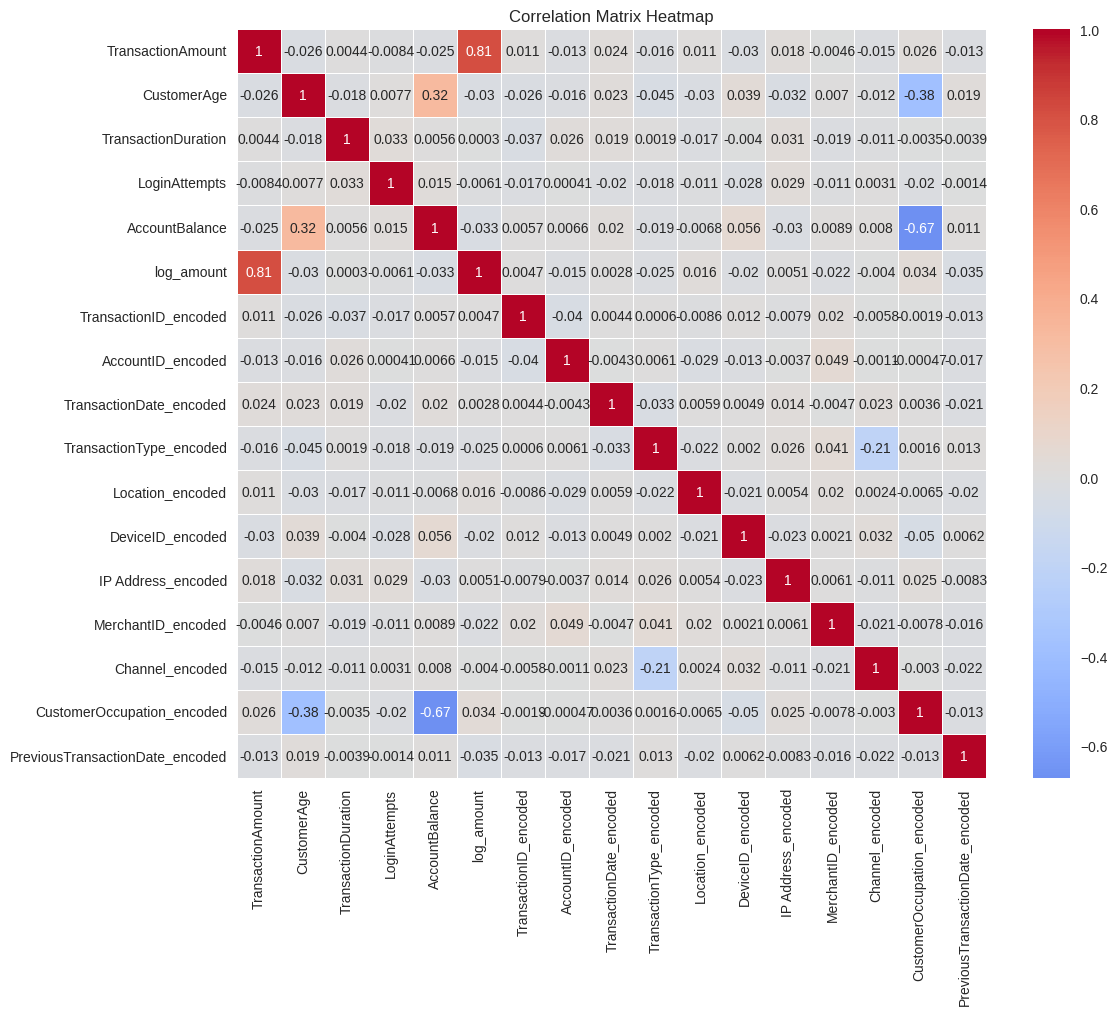


High correlations (|r| > 0.7):
  TransactionAmount vs log_amount: 0.813

4. SCATTER PLOT RELATIONSHIPS
------------------------------


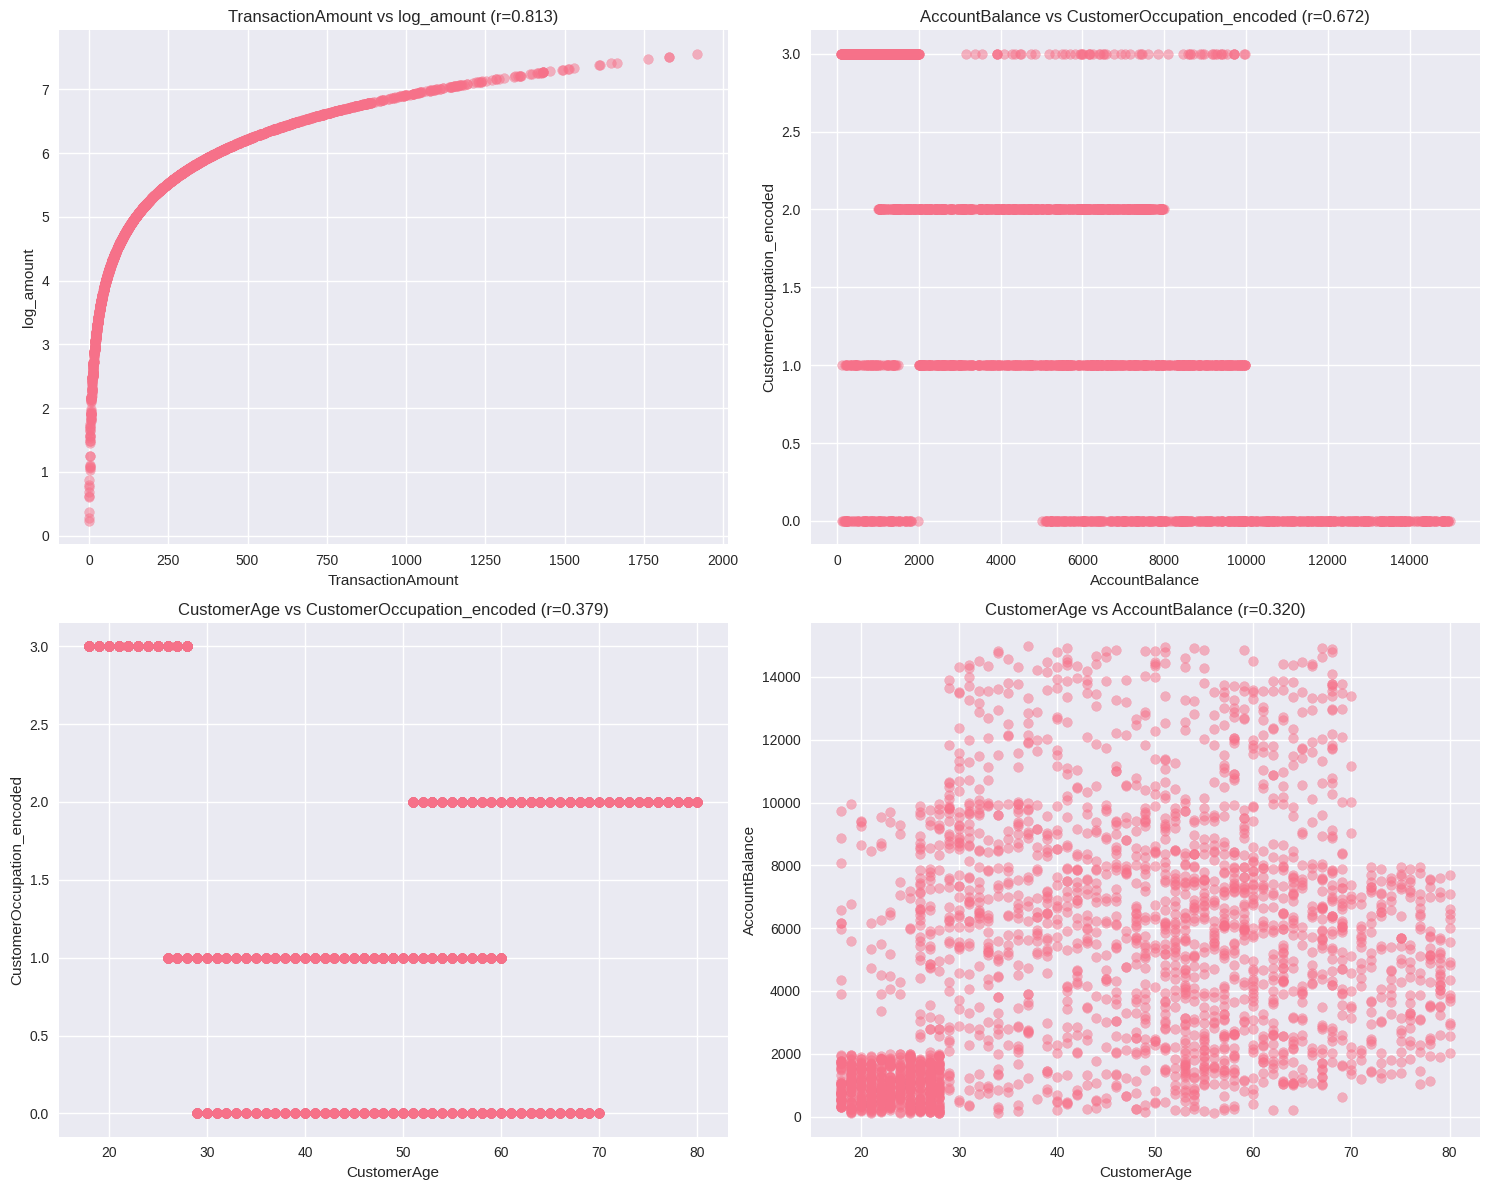

In [16]:
analyzer.bivariate_analysis()


MULTIVARIATE ANALYSIS

1. PRINCIPAL COMPONENT ANALYSIS
------------------------------
First 5 components explain 42.13% of variance


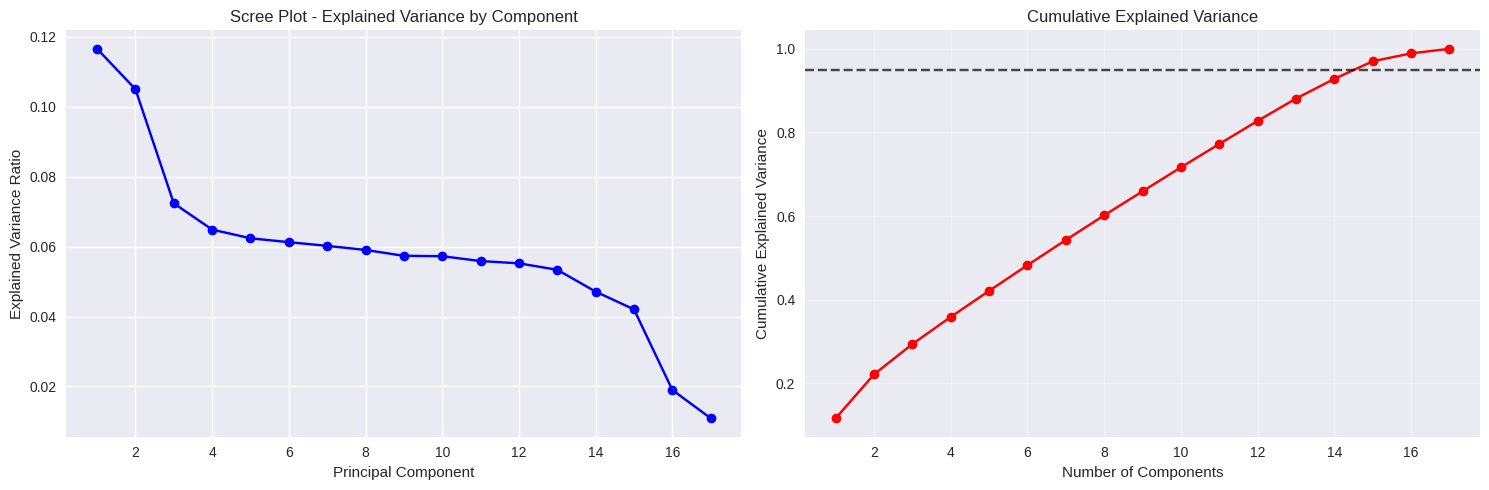


2. CLUSTERING ANALYSIS
------------------------------


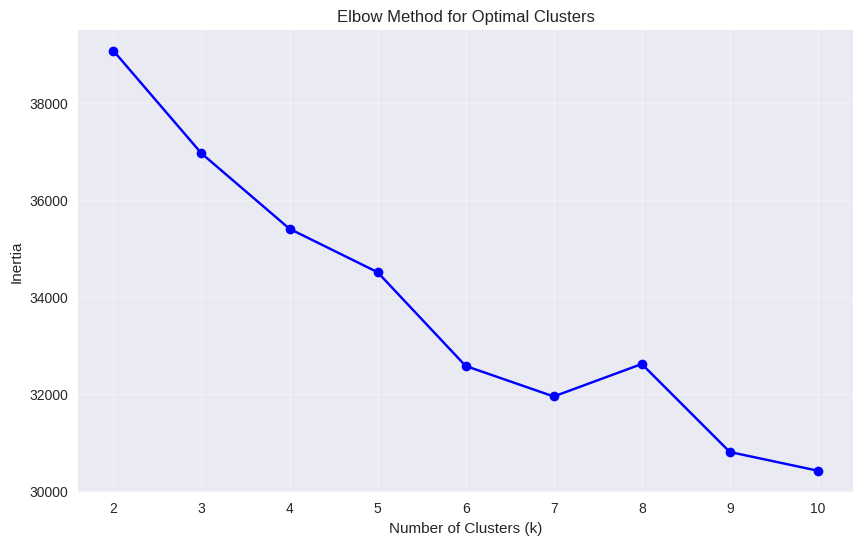

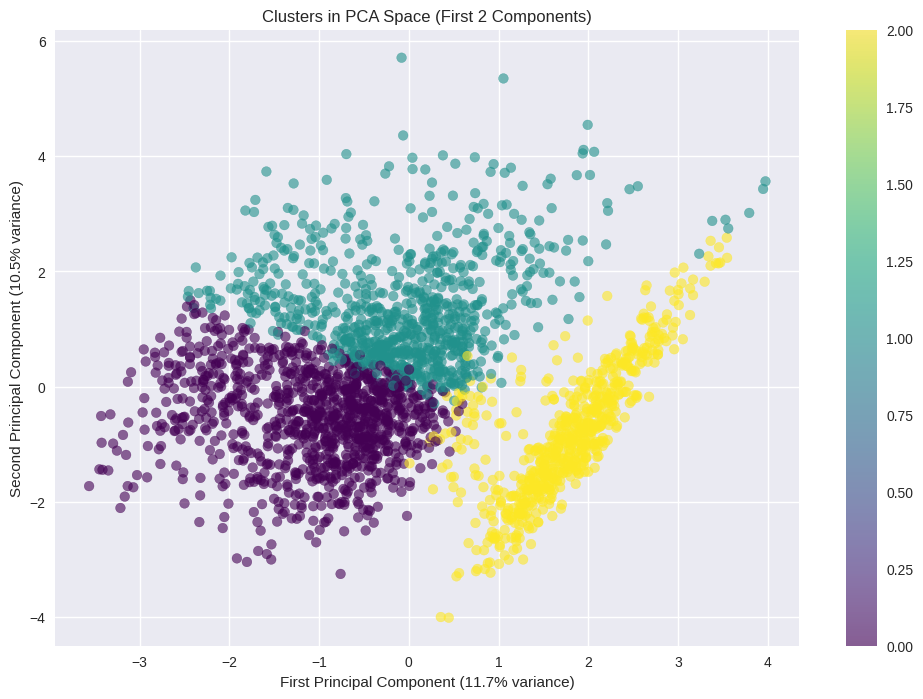


3. FEATURE INTERACTIONS
------------------------------
Created interaction feature: TransactionAmount_CustomerAge_interaction


In [26]:
pca_model, pca_data, clusters = analyzer.multivariate_analysis()


FEATURE SELECTION
No target variable found. Creating a dummy target for demonstration.
Target variable: fraud
Number of features: 18
Features: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'log_amount', 'TransactionID_encoded', 'AccountID_encoded', 'TransactionDate_encoded', 'TransactionType_encoded', 'Location_encoded', 'DeviceID_encoded', 'IP Address_encoded', 'MerchantID_encoded', 'Channel_encoded', 'CustomerOccupation_encoded', 'PreviousTransactionDate_encoded', 'TransactionAmount_CustomerAge_interaction']

1. STATISTICAL FEATURE SELECTION
------------------------------

Top features by F-score:
                                      feature      f_score       f_pvalue  \
0                           TransactionAmount  2191.759104   0.000000e+00   
17  TransactionAmount_CustomerAge_interaction  1282.254612  3.246060e-227   
5                                  log_amount   368.999527   7.750329e-77   
8                     TransactionDa

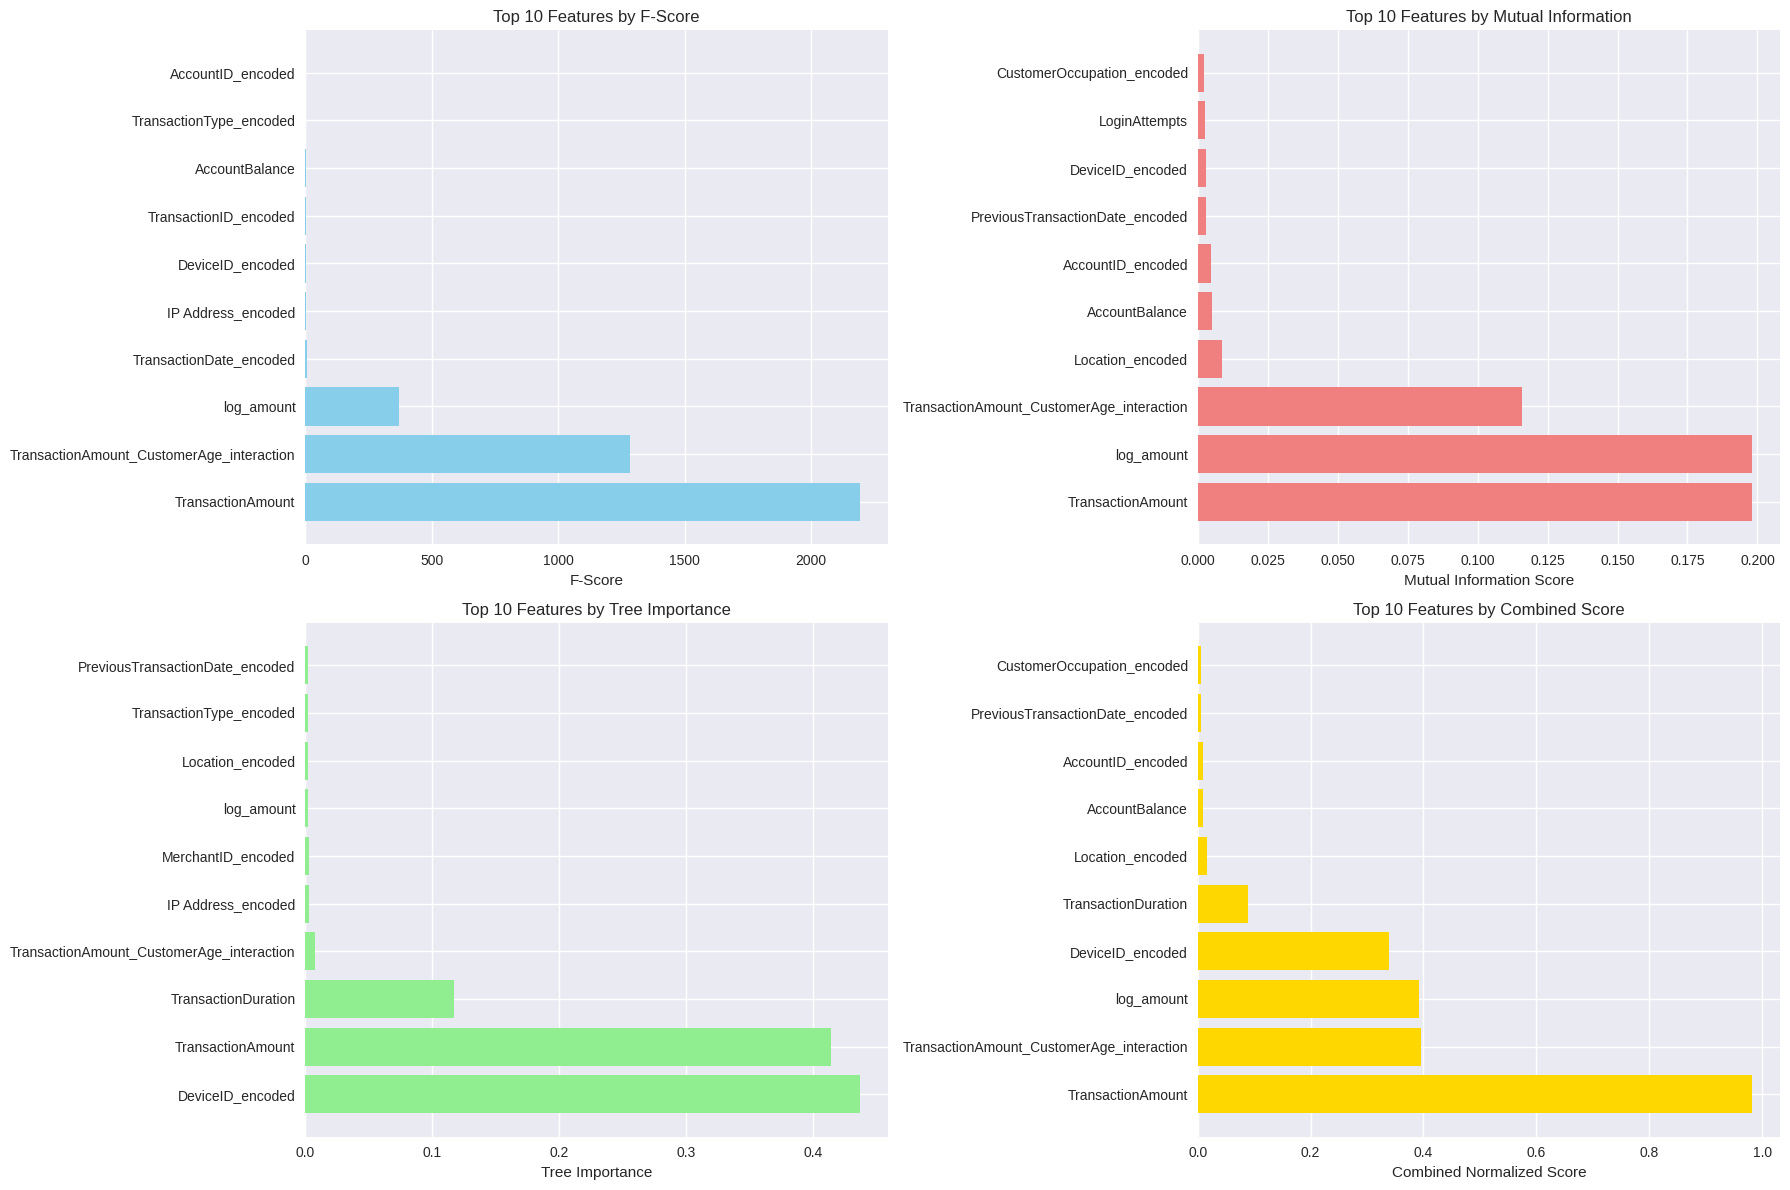

In [28]:
feature_rankings = analyzer.feature_selection()

In [29]:
dashboard = analyzer.create_dashboard()


INTERACTIVE DASHBOARD


In [30]:
insights = analyzer.generate_insights()


KEY INSIGHTS AND RECOMMENDATIONS
1. DATASET OVERVIEW:
   • Dataset contains 2,512 transactions with 30 features
   • 19 numerical and 10 categorical variables
   • Fraud rate: 5.02% (Moderately imbalanced dataset)

2. DATA QUALITY:
   • Missing values: 0.00% of total data

3. KEY STATISTICAL FINDINGS:
   • Transaction amounts range from $0.26 to $1,919.11
   • Median transaction: $211.14
   • Median fraud amount: $1,112.47 vs Normal: $195.65

4. MOST IMPORTANT FEATURES:
   • TransactionAmount: 0.326
   • fraud: 0.305
   • log_amount: 0.297
   • TransactionAmount_CustomerAge_interaction: 0.056
   • CustomerAge: 0.004

5. RECOMMENDATIONS:
   • Implement real-time monitoring for high-value transactions
   • Consider ensemble methods for better fraud detection
   • Implement feature engineering for time-based patterns
   • Regular model retraining due to evolving fraud patterns


In [33]:
df = detect_anomalies(cleaned_data)

Detected 252 anomalies using isolation_forest


In [34]:
create_fraud_score(df)

Fraud risk score created!
Score distribution: count    2512.000000
mean       40.059763
std        13.168606
min         0.000000
25%        31.106787
50%        39.070060
75%        47.244291
max       100.000000
dtype: float64


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,...,DeviceID_encoded,IP Address_encoded,MerchantID_encoded,Channel_encoded,CustomerOccupation_encoded,PreviousTransactionDate_encoded,TransactionAmount_CustomerAge_interaction,fraud,anomaly,fraud_risk_score
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,...,365,186,14,0,0,105,986.30,0,1,15.701061
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,...,50,82,51,0,0,192,25584.32,0,1,34.426821
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,...,229,343,8,2,3,41,2399.51,0,1,26.995409
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,...,182,300,1,2,3,163,4797.00,0,1,31.149057
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,...,298,501,90,2,3,16,349.70,0,-1,44.739503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,TX002508,AC00297,856.21,2023-04-26 17:09:36,Credit,Colorado Springs,D000625,21.157.41.17,M072,Branch,...,605,325,71,1,0,305,28254.93,0,-1,37.150706
2508,TX002509,AC00322,251.54,2023-03-22 17:36:48,Debit,Tucson,D000410,49.174.157.140,M029,Branch,...,395,448,28,1,0,318,12073.92,0,1,41.915852
2509,TX002510,AC00095,28.63,2023-08-21 17:08:50,Debit,San Diego,D000095,58.1.27.124,M087,Branch,...,93,474,86,1,2,136,1603.28,0,1,46.780366
2510,TX002511,AC00118,185.97,2023-02-24 16:24:46,Debit,Denver,D000634,21.190.11.223,M041,Online,...,614,326,40,2,3,358,4277.31,0,1,40.325630
